## Question 3

In [3]:
import os
import sys

if 'CONDA_DEFAULT_ENV' in os.environ or 'CONDA_PREFIX' in os.environ:
    print("Running within a Conda environment.")
else:
    print("Not running within a Conda environment (or Conda is not active).")

print(f"Python interpreter path: {sys.executable}")

Running within a Conda environment.
Python interpreter path: c:\Users\neoha\anaconda3\python.exe


In [4]:
import torch

if torch.backends.mps.is_available():
    my_device = torch.device('mps')
elif torch.cuda.is_available():
    my_device = torch.device('cuda')
else:
    my_device = torch.device('cpu')

print(my_device)

cuda


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

# Transformation for the input data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406] , std=[0.229, 0.224, 0.225])
])

#### **3-(a)**

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

def get_resnet18():
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    
    model.conv1 = nn.Conv2d(
        in_channels=3, 
        out_channels=64, 
        kernel_size=7, 
        stride=1,      # Changed from 2 to 1
        padding=3,     # Kept at 3
        bias=False
    )
    
    model.maxpool = nn.MaxPool2d(
        kernel_size=3, 
        stride=1,      # Changed from 2 to 1
        padding=1
    )
    
    
    num_ftrs = model.fc.in_features  # 512
    model.fc = nn.Linear(num_ftrs, 100) # 100 subjects
    
    return model

In [ ]:
from torchsummary import summary

# Create the model
model = get_resnet18()

# Create a dummy input 
input_tensor = torch.randn(1, 3, 64, 64)

x = model.conv1(input_tensor)
x = model.bn1(x)
x = model.relu(x)
print(f"After Conv1: {x.shape}") # Should be 64x64

x = model.maxpool(x)
print(f"After MaxPool: {x.shape}") # Should be 64x64

x = model.layer1(x)
print(f"After Layer1: {x.shape}") # Should be 64x64

x = model.layer2(x)
print(f"After Layer2: {x.shape}") # Should be 32x32 (First downsample)

x = model.layer3(x)
print(f"After Layer3: {x.shape}") # Should be 16x16 (Second downsample)

x = model.layer4(x)
print(f"After Layer4: {x.shape}") # Should be 8x8 (Third downsample)

# Check if we met the requirement
if x.shape[2:] == (8, 8):
    print("\nSUCCESS: Final feature map size is 8x8x512")
else:
    print(f"\nFAILURE: Final feature map size is {x.shape}")

summary(model.cuda(), input_size=(3, 64, 64))

After Conv1: torch.Size([1, 64, 64, 64])
After MaxPool: torch.Size([1, 64, 64, 64])
After Layer1: torch.Size([1, 64, 64, 64])
After Layer2: torch.Size([1, 128, 32, 32])
After Layer3: torch.Size([1, 256, 16, 16])
After Layer4: torch.Size([1, 512, 8, 8])

SUCCESS: Final feature map size is 8x8x512
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             12

#### **3-(b)** : Baseline 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import os

DATA_DIR = './Helperdata/face_dataset'  
BATCH_SIZE = 32
NUM_CLASSES = 100            

In [ ]:

data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=DATA_DIR + "/facescrub_train", transform=data_transforms)
test_dataset = datasets.ImageFolder(root=DATA_DIR + "/facescrub_test", transform=data_transforms)

train_size = len(train_dataset)
test_size = len(test_dataset)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Data loaded: {train_size} training samples, {test_size} test samples.")

Data loaded: 4000 training samples, 1000 test samples.


In [ ]:

def get_frozen_resnet18(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    original_weights = model.conv1.weight.data.clone()
    model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3, bias=False)
    model.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    model.conv1.weight.data = original_weights
    
    # Freeze ALL parameters first
    for param in model.parameters():
        param.requires_grad = False
        
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model

baseline_model = get_frozen_resnet18(NUM_CLASSES)
baseline_model = baseline_model.to(my_device)

In [131]:
history = {
    'train_loss': [], 'test_loss': [],
    'train_acc': [], 'test_acc': []
}

In [ ]:
import torch
import numpy as np

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            # Loss did not improve significantly
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # Loss improved
            self.best_loss = val_loss
            self.counter = 0  # Reset counter

    

In [134]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.fc.parameters(), lr=0.001, weight_decay=1e-7)

In [ ]:

def train_model(model, NUM_EPOCHS):
    print("Starting Training (Linear Probing)...")
    
    early_stopping = EarlyStopping(patience=5)

    if(NUM_EPOCHS > 50):
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(my_device), labels.to(my_device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        epoch_train_loss = running_loss / train_size
        epoch_train_acc = correct / total
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(my_device), labels.to(my_device)
                outputs = model(inputs)
                loss = criterion(outputs, labels) # Calculate test loss
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_test_loss = running_loss / test_size
        epoch_test_acc = correct / total

        if(NUM_EPOCHS > 50):
            scheduler.step()

        history['train_loss'].append(epoch_train_loss)
        history['test_loss'].append(epoch_test_loss)
        history['train_acc'].append(epoch_train_acc)
        history['test_acc'].append(epoch_test_acc)
    
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
            f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | "
            f"Test Loss: {epoch_test_loss:.4f} Acc: {epoch_test_acc:.4f}")
        
        early_stopping(epoch_test_loss)

        if early_stopping.early_stop:
            print("Early stopping triggered! Training stopped.")
            break # Break out of the for loop


def evaluate_model(model):
    print("\nStarting Evaluation on Test Set...")
    model.eval() # Set to evaluation mode
    correct = 0
    total = 0
    
    # No gradient needed for evaluation
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(my_device), labels.to(my_device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    acc = correct / total
    print(f'Model Test Accuracy: {acc:.4f} ({correct}/{total})')

In [136]:
import matplotlib.pyplot as plt 
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

def plot_metrics(history, NUM_EPOCHS):    
    epochs_range = range(1, NUM_EPOCHS + 1)

    plt.figure(figsize=(14, 5))

    # --- Graph 1: Loss vs. Epoch ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_loss'], label='Training Loss', marker='o')
    plt.plot(epochs_range, history['test_loss'], label='Test Loss', marker='o')
    plt.title('Training and Test Loss vs. Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # --- Graph 2: Accuracy vs. Epoch ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_acc'], label='Training Accuracy', marker='o')
    plt.plot(epochs_range, history['test_acc'], label='Test Accuracy', marker='o')
    plt.title('Classification Accuracy vs. Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [141]:
baseline_model = get_frozen_resnet18(NUM_CLASSES)
baseline_model = baseline_model.to(my_device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.fc.parameters(), lr=0.001, weight_decay=1e-7)

train_model(baseline_model, NUM_EPOCHS=80)
evaluate_model(baseline_model)

Starting Training (Linear Probing)...
Epoch 1/80 | Train Loss: 4.4548 Acc: 0.0517 | Test Loss: 4.0128 Acc: 0.1320
Epoch 2/80 | Train Loss: 3.5584 Acc: 0.2477 | Test Loss: 3.4475 Acc: 0.2850
Epoch 3/80 | Train Loss: 2.9655 Acc: 0.4130 | Test Loss: 3.0683 Acc: 0.3440
Epoch 4/80 | Train Loss: 2.5383 Acc: 0.5085 | Test Loss: 2.8426 Acc: 0.3920
Epoch 5/80 | Train Loss: 2.2095 Acc: 0.5905 | Test Loss: 2.6222 Acc: 0.4350
Epoch 6/80 | Train Loss: 1.9639 Acc: 0.6300 | Test Loss: 2.4984 Acc: 0.4440
Epoch 7/80 | Train Loss: 1.7454 Acc: 0.6777 | Test Loss: 2.3831 Acc: 0.4670
Epoch 8/80 | Train Loss: 1.5948 Acc: 0.7065 | Test Loss: 2.3016 Acc: 0.4670
Epoch 9/80 | Train Loss: 1.4408 Acc: 0.7480 | Test Loss: 2.2162 Acc: 0.4980
Epoch 10/80 | Train Loss: 1.3205 Acc: 0.7638 | Test Loss: 2.1269 Acc: 0.5260
Epoch 11/80 | Train Loss: 1.1582 Acc: 0.8290 | Test Loss: 2.0434 Acc: 0.5460
Epoch 12/80 | Train Loss: 1.1304 Acc: 0.8387 | Test Loss: 2.0412 Acc: 0.5540
Epoch 13/80 | Train Loss: 1.1233 Acc: 0.8417 | 

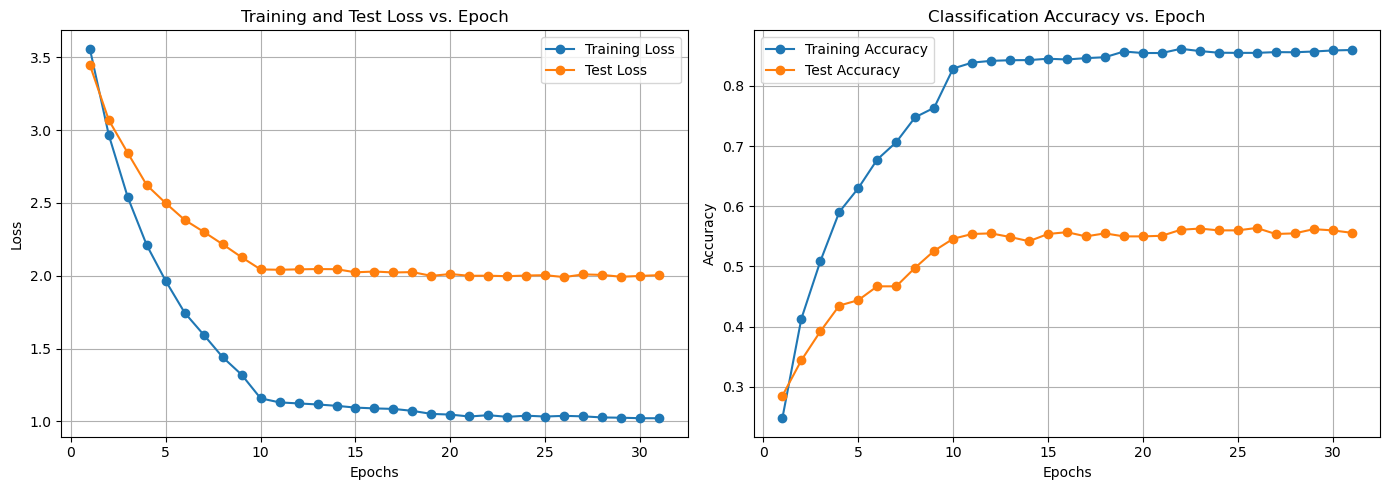

In [155]:
plot_metrics(history, NUM_EPOCHS=31)

In [144]:
# Define the path (convention uses .pth or .pt)
PATH = 'face_resnet18_weights.pth'

# Save only the parameters
torch.save(baseline_model.state_dict(), PATH)
print(f"Model weights saved to {PATH}")

Model weights saved to face_resnet18_weights.pth


#### **3-(c)** : Model A

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),  # Augmentation
    transforms.RandomRotation(degrees=10),   # Augmentation
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [157]:
# Load Datasets
try:
    train_dataset = datasets.ImageFolder(root=DATA_DIR + "/facescrub_train", transform=data_transforms)
    test_dataset = datasets.ImageFolder(root=DATA_DIR + "/facescrub_test", transform=data_transforms)

    train_size = len(train_dataset)
    test_size = len(test_dataset)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Data loaded: {train_size} training samples, {test_size} test samples.")
except Exception as e:
    print(f"Error loading data: {e}")

Data loaded: 4000 training samples, 1000 test samples.


In [ ]:
def get_model_a_resnet18(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    original_weights = model.conv1.weight.data.clone()
    model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3, bias=False)
    model.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    model.conv1.weight.data = original_weights

    for param in model.parameters():
        param.requires_grad = False

    
    for param in model.layer4.parameters():
        param.requires_grad = True
        
    
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model

model_a = get_model_a_resnet18(NUM_CLASSES)
model_a = model_a.to(my_device)

In [159]:
history = {
    'train_loss': [], 'test_loss': [],
    'train_acc': [], 'test_acc': []
}

criterion = nn.CrossEntropyLoss()

trainable_params = [
    {'params': model_a.layer4.parameters()},
    {'params': model_a.fc.parameters()}
]

optimizer = optim.Adam(trainable_params, lr=0.001, weight_decay=1e-7)

train_model(model_a, NUM_EPOCHS=80)
evaluate_model(model_a)

Starting Training (Linear Probing)...


KeyboardInterrupt: 

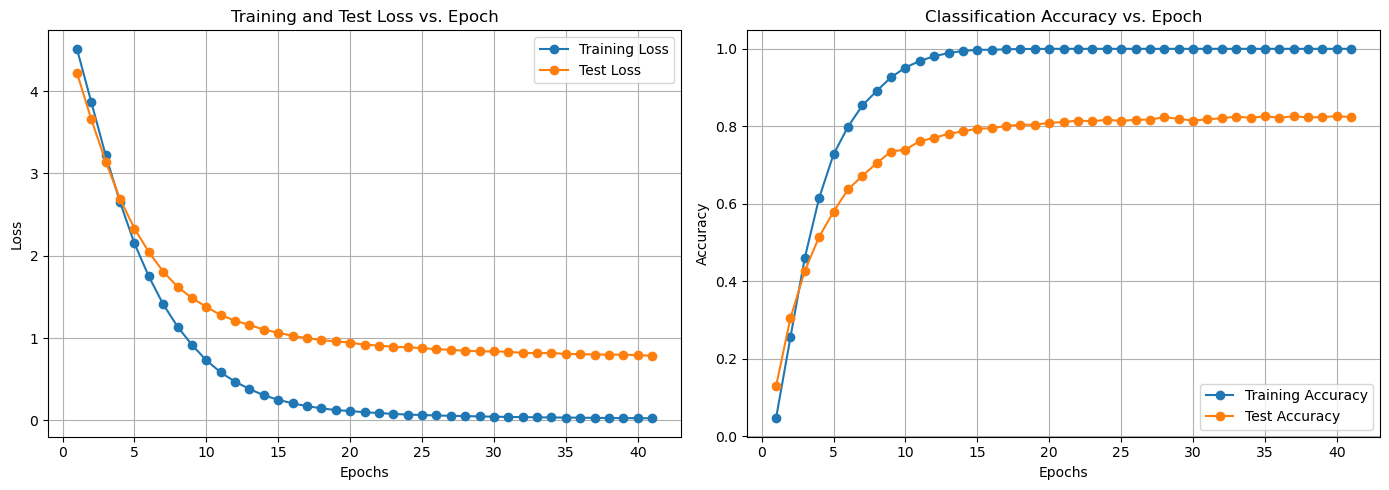

In [ ]:
plot_metrics(history, NUM_EPOCHS=41)

In [ ]:
PATH = 'face_resnet18_modelA_weights.pth'

# Save only the parameters
torch.save(model_a.state_dict(), PATH)
print(f"Model weights saved to {PATH}")

Model weights saved to face_resnet18_modelA_weights.pth


#### **3 - (d)** : Model B

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),  # Augmentation
    transforms.RandomRotation(degrees=10),   # Augmentation
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load Datasets
try:
    train_dataset = datasets.ImageFolder(root=DATA_DIR + "/facescrub_train", transform=train_transforms)
    test_dataset = datasets.ImageFolder(root=DATA_DIR + "/facescrub_test", transform=test_transforms)

    train_size = len(train_dataset)
    test_size = len(test_dataset)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Data loaded: {train_size} training samples, {test_size} test samples.")
except Exception as e:
    print(f"Error loading data: {e}")

Data loaded: 4000 training samples, 1000 test samples.


In [ ]:
def get_model_b_resnet18(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    original_weights = model.conv1.weight.data.clone()
    model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3, bias=False)
    model.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    model.conv1.weight.data = original_weights

    # FREEZE EVERYTHING FIRST
    for param in model.parameters():
        param.requires_grad = False

    # UNFREEZE Conv5_x and Conv4_x
    for param in model.layer3.parameters():
        param.requires_grad = True
    for param in model.layer4.parameters():
        param.requires_grad = True
        
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model

model_b = get_model_b_resnet18(NUM_CLASSES)
model_b = model_b.to(my_device)

In [ ]:
history = {
    'train_loss': [], 'test_loss': [],
    'train_acc': [], 'test_acc': []
}

criterion = nn.CrossEntropyLoss()

trainable_params = [
    {'params': model_b.layer3.parameters()},
    {'params': model_b.layer4.parameters()},
    {'params': model_b.fc.parameters()}
]

optimizer = optim.Adam(trainable_params, lr=0.001, weight_decay=1e-7)

train_model(model_b, NUM_EPOCHS=80)
evaluate_model(model_b)

Starting Training (Linear Probing)...
Epoch 1/80 | Train Loss: 4.4920 Acc: 0.0542 | Test Loss: 4.1434 Acc: 0.1330
Epoch 2/80 | Train Loss: 3.6858 Acc: 0.2925 | Test Loss: 3.4407 Acc: 0.3310
Epoch 3/80 | Train Loss: 2.9165 Acc: 0.5490 | Test Loss: 2.8154 Acc: 0.4970
Epoch 4/80 | Train Loss: 2.2474 Acc: 0.7232 | Test Loss: 2.3057 Acc: 0.6350
Epoch 5/80 | Train Loss: 1.7075 Acc: 0.8145 | Test Loss: 1.9045 Acc: 0.7140
Epoch 6/80 | Train Loss: 1.2627 Acc: 0.8905 | Test Loss: 1.6045 Acc: 0.7450
Epoch 7/80 | Train Loss: 0.9336 Acc: 0.9287 | Test Loss: 1.3865 Acc: 0.7810
Epoch 8/80 | Train Loss: 0.6904 Acc: 0.9563 | Test Loss: 1.2451 Acc: 0.8030
Epoch 9/80 | Train Loss: 0.5068 Acc: 0.9798 | Test Loss: 1.1204 Acc: 0.8230
Epoch 10/80 | Train Loss: 0.3717 Acc: 0.9910 | Test Loss: 1.0438 Acc: 0.8220
Epoch 11/80 | Train Loss: 0.2894 Acc: 0.9945 | Test Loss: 1.0240 Acc: 0.8240
Epoch 12/80 | Train Loss: 0.2812 Acc: 0.9958 | Test Loss: 1.0171 Acc: 0.8240
Epoch 13/80 | Train Loss: 0.2725 Acc: 0.9965 | 

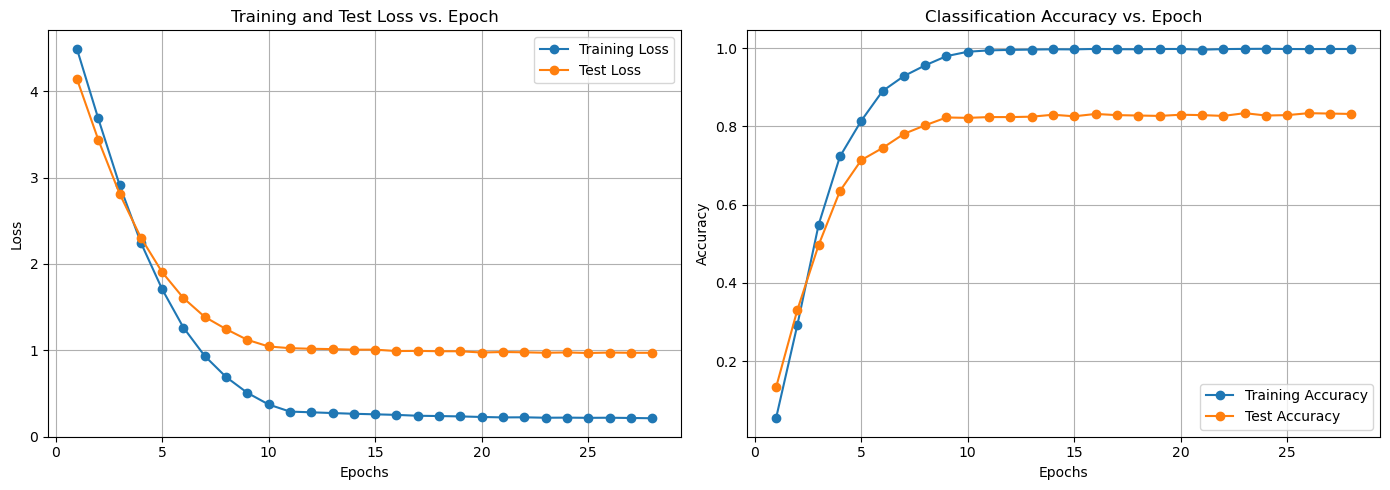

In [66]:
plot_metrics(history, NUM_EPOCHS=28)

In [ ]:
PATH = 'face_resnet18_modelB_weights.pth'

# Save only the parameters
torch.save(model_b.state_dict(), PATH)
print(f"Model weights saved to {PATH}")

Model weights saved to face_resnet18_modelB_weights.pth


#### **3-(e)**

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),  # Augmentation
    transforms.RandomRotation(degrees=10),   # Augmentation
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load Datasets
try:
    train_dataset = datasets.ImageFolder(root=DATA_DIR + "/facescrub_train", transform=train_transforms)
    test_dataset = datasets.ImageFolder(root=DATA_DIR + "/facescrub_test", transform=test_transforms)

    train_size = len(train_dataset)
    test_size = len(test_dataset)
    BATCH_SIZE = 16
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Data loaded: {train_size} training samples, {test_size} test samples.")
except Exception as e:
    print(f"Error loading data: {e}")

Data loaded: 4000 training samples, 1000 test samples.


In [ ]:
def get_model_c_resnet18(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    original_weights = model.conv1.weight.data.clone()
    model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3, bias=False)
    model.conv1.weight.data = original_weights
    model.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

    # UNFREEZE all layers
    for param in model.parameters():
        param.requires_grad = True
    
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model

model_c = get_model_c_resnet18(NUM_CLASSES)
model_c = model_c.to(my_device)

In [102]:
history = {
    'train_loss': [], 'test_loss': [],
    'train_acc': [], 'test_acc': []
}

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_c.parameters(), lr=0.00001)

train_model(model_c, NUM_EPOCHS=80)
evaluate_model(model_c)

Starting Training (Linear Probing)...
Epoch 1/80 | Train Loss: 4.6670 Acc: 0.0147 | Test Loss: 4.5087 Acc: 0.0280
Epoch 2/80 | Train Loss: 4.3502 Acc: 0.0638 | Test Loss: 4.1747 Acc: 0.0910
Epoch 3/80 | Train Loss: 4.0173 Acc: 0.1805 | Test Loss: 3.8157 Acc: 0.2200
Epoch 4/80 | Train Loss: 3.6960 Acc: 0.3165 | Test Loss: 3.4715 Acc: 0.3650
Epoch 5/80 | Train Loss: 3.3843 Acc: 0.4387 | Test Loss: 3.1636 Acc: 0.4770
Epoch 6/80 | Train Loss: 3.1142 Acc: 0.5165 | Test Loss: 2.8749 Acc: 0.5440
Epoch 7/80 | Train Loss: 2.8459 Acc: 0.5968 | Test Loss: 2.6200 Acc: 0.6020
Epoch 8/80 | Train Loss: 2.5971 Acc: 0.6495 | Test Loss: 2.3873 Acc: 0.6560
Epoch 9/80 | Train Loss: 2.3760 Acc: 0.6967 | Test Loss: 2.1742 Acc: 0.6960
Epoch 10/80 | Train Loss: 2.1824 Acc: 0.7362 | Test Loss: 1.9588 Acc: 0.7360
Epoch 11/80 | Train Loss: 2.0322 Acc: 0.7837 | Test Loss: 1.9574 Acc: 0.7440
Epoch 12/80 | Train Loss: 2.0095 Acc: 0.7817 | Test Loss: 1.9283 Acc: 0.7440
Epoch 13/80 | Train Loss: 2.0001 Acc: 0.7798 | 

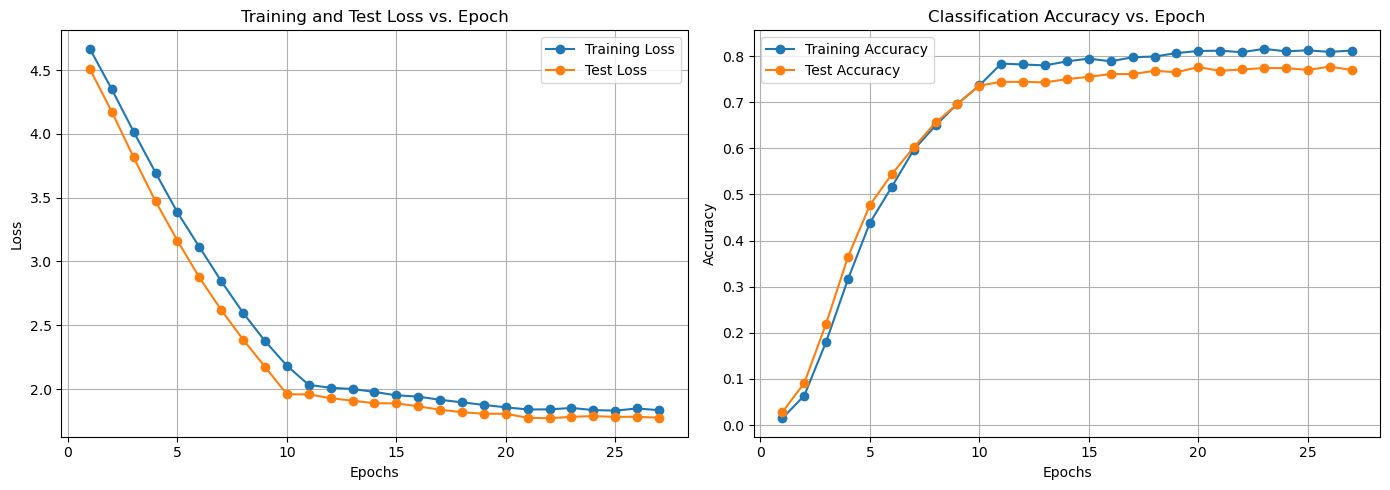

In [104]:
plot_metrics(history, NUM_EPOCHS=27)

In [ ]:
PATH = 'face_resnet18_modelC_weights.pth'

# Save only the parameters
torch.save(model_c.state_dict(), PATH)
print(f"Model weights saved to {PATH}")

Model weights saved to face_resnet18_modelC_weights.pth


#### **3-(f)**

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),  # Augmentation
    transforms.RandomRotation(degrees=10),   # Augmentation
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load Datasets
try:
    train_dataset = datasets.ImageFolder(root=DATA_DIR + "/facescrub_train", transform=train_transforms)
    test_dataset = datasets.ImageFolder(root=DATA_DIR + "/facescrub_test", transform=test_transforms)

    train_size = len(train_dataset)
    test_size = len(test_dataset)
    BATCH_SIZE = 16
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Data loaded: {train_size} training samples, {test_size} test samples.")
except Exception as e:
    print(f"Error loading data: {e}")

Data loaded: 4000 training samples, 1000 test samples.


In [ ]:
def get_model_d_resnet18(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    original_weights = model.conv1.weight.data.clone()
    model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3, bias=False)
    model.conv1.weight.data = original_weights
    model.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

    # FREEZE all layers
    for param in model.parameters():
        param.requires_grad = False
    
    
    num_ftrs = model.fc.in_features # 512
    
    model.fc = nn.Sequential(
        # --- Hidden Layer 1 ---
        nn.Linear(num_ftrs, 256),
        nn.BatchNorm1d(256),       
        nn.ReLU(),
        nn.Dropout(p=0.5),         # Dropout for regularization
        
        # --- Hidden Layer 2 ---
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        
        nn.Linear(128, num_classes)
    )
    
    return model

model_d = get_model_d_resnet18(NUM_CLASSES)
model_d = model_d.to(my_device)

In [162]:
history = {
    'train_loss': [], 'test_loss': [],
    'train_acc': [], 'test_acc': []
}

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_d.fc.parameters(), lr=0.001, weight_decay=1e-7)

train_model(model_d, NUM_EPOCHS=80)
evaluate_model(model_d)

Starting Training (Linear Probing)...
Epoch 1/80 | Train Loss: 4.4125 Acc: 0.0475 | Test Loss: 3.9437 Acc: 0.1220
Epoch 2/80 | Train Loss: 3.8147 Acc: 0.1353 | Test Loss: 3.4603 Acc: 0.2150
Epoch 3/80 | Train Loss: 3.4232 Acc: 0.1933 | Test Loss: 3.1004 Acc: 0.2900
Epoch 4/80 | Train Loss: 3.1799 Acc: 0.2338 | Test Loss: 2.9019 Acc: 0.3200
Epoch 5/80 | Train Loss: 3.0116 Acc: 0.2527 | Test Loss: 2.7220 Acc: 0.3520
Epoch 6/80 | Train Loss: 2.9115 Acc: 0.2840 | Test Loss: 2.6618 Acc: 0.3550
Epoch 7/80 | Train Loss: 2.8131 Acc: 0.3008 | Test Loss: 2.5707 Acc: 0.3710
Epoch 8/80 | Train Loss: 2.7160 Acc: 0.3170 | Test Loss: 2.4965 Acc: 0.3820
Epoch 9/80 | Train Loss: 2.7045 Acc: 0.3205 | Test Loss: 2.4340 Acc: 0.4020
Epoch 10/80 | Train Loss: 2.5952 Acc: 0.3377 | Test Loss: 2.3735 Acc: 0.4210
Epoch 11/80 | Train Loss: 2.4878 Acc: 0.3703 | Test Loss: 2.3347 Acc: 0.4390
Epoch 12/80 | Train Loss: 2.4704 Acc: 0.3785 | Test Loss: 2.2913 Acc: 0.4370
Epoch 13/80 | Train Loss: 2.4591 Acc: 0.3795 | 

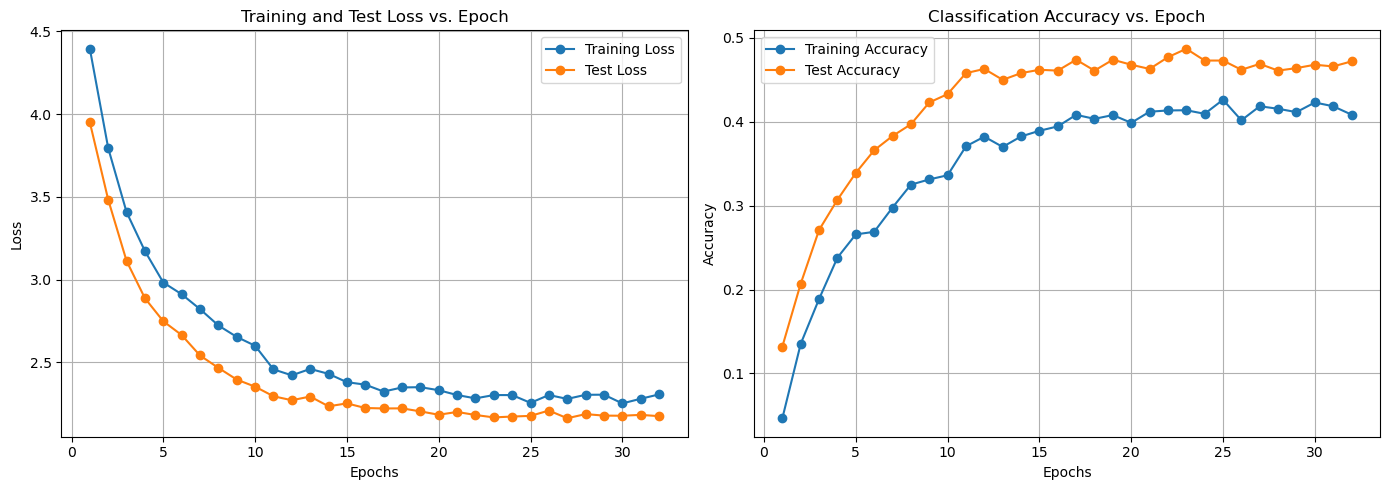

In [118]:
plot_metrics(history, NUM_EPOCHS=32)

In [ ]:
PATH = 'face_resnet18_modelD_weights.pth'

# Save only the parameters
torch.save(model_d.state_dict(), PATH)
print(f"Model weights saved to {PATH}")

Model weights saved to face_resnet18_modelD_weights.pth
